<a href="https://colab.research.google.com/github/NID123-CH/NLP--Hugging-Face-Project/blob/main/DSR_40_LSTM_Language_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [14]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 100

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

# Data

In [15]:
batch_size = 32 # Not for SGD!
seed = 42

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

dataset_original_all   = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 67 files.
Found 53 files.
Found 14 files.


In [16]:
for x in dataset_original_all.take(1):
    print(x.shape)
    print(x[0])

(32,)
tf.Tensor(b'the call of cthulhu\n\nof such great powers or beings there may be conceivably a survival . . .a survival of a hugely remote period when . . .consciousness was manifested , perhaps , in shapes and forms long since withdrawn before the tide of advancing humanity . . .forms of which poetry and legend alone have caught a flying memory and called them gods , monsters , mythical beings of all sorts and kinds . . .\n\n--algernon blackwood\n\ni . the horror in clay\n\nthe most merciful thing in the world , i think , is the inability of the human mind to correlate all its contents . we live on a placid island of ignorance in the midst of black seas of infinity , and it was not meant that we should voyage far . the sciences , each straining in its own direction , have hitherto harmed us little ; but some day the piecing together of dissociated knowledge will open up such terrifying vistas of reality , and of our frightful position therein , that we shall either go mad from the

# Create the text vectorizer.

In [17]:
vocabulary_size = 30_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
print(vocabulary)

['', '[UNK]', 'the', ',', 'and', 'of', '.', 'to', 'a', 'in', 'i', 'was', 'that', 'had', 'he', 'it', 'as', 'with', 'his', ';', 'for', 'at', 'which', 'from', 'on', 'not', 'but', 'my', 'were', 'by', 'they', 'all', 'be', 'or', 'this', 'there', 'me', 'have', 'could', 'one', 'when', 'him', 'no', 'an', 'we', 'been', 'some', 'what', 'their', 'so', 'would', 'is', 'its', 'more', 'out', 'old', 'them', 'only', 'now', 'about', 'up', 'did', 'into', 'before', 'seemed', 'very', 'then', 'than', 'great', 'those', 'through', 'time', 'who', 'after', 'any', 'saw', 'where', 'even', 'you', 'things', 'though', 'must', 'our', 'over', 'if', 'down', 'other', 'man', 'like', 'these', 'came', 'found', 'might', 'such', 'whose', 'are', 'night', 'upon', 'strange', 'never', 'thing', '?', 'once', 'made', 'much', 'place', 'still', 'long', 'men', 'certain', 'most', 'knew', 'beyond', 'first', 'many', 'carter', 'see', 'come', 'thought', 'house', 'heard', 'black', 'two', 'last', 'too', 'yet', 'seen', 'back', 'again', 'told',

# Create dataset for autoregression.

In [18]:
sequence_length = 128
padding_token_id = 0

def create_dataset_for_autoregression(dataset, hop_length=1):
    x_inputs = []
    y_outputs = []

    for books in dataset:

        books = encoder(books).numpy() # Encodes all books into word indices.

        for book in tqdm(books):

            # Remove the padding tokens.
            book = [index for index in list(book) if index != padding_token_id]

            for start_index in range(0, len(book) - sequence_length, hop_length):
                x = book[start_index:start_index + sequence_length]
                y = book[start_index + 1: start_index + sequence_length + 1]
                assert len(x) == sequence_length
                assert len(y) == sequence_length

                x_inputs += [x]
                y_outputs += [y]

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 14/14 [00:00<00:00, 31.03it/s]


In [19]:
def decode(indices):
    return " ".join([vocabulary[index] for index in indices])

for input, output in dataset_train.take(8):
    print("in: ", decode(input))
    print("out:", decode(output))
    print("")

in:  the case of charles dexter ward the essential saltes of animals may be so prepared and preserved , that an ingenious man may have the whole ark of noah in his own studie , and raise the fine shape of an animal out of its ashes at his pleasure ; and by the lyke method from the essential saltes of humane dust , a philosopher may , without any criminal necromancy , call up the shape of any dead ancestour from the dust whereinto his bodie has been incinerated . [UNK] contents i . a result and a prologue ii . an antecedent and a horror iii . a search and an evocation iv . a mutation and a madness v . a nightmare and a cataclysm i
out: case of charles dexter ward the essential saltes of animals may be so prepared and preserved , that an ingenious man may have the whole ark of noah in his own studie , and raise the fine shape of an animal out of its ashes at his pleasure ; and by the lyke method from the essential saltes of humane dust , a philosopher may , without any criminal necromanc

In [20]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

## Train the model

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

embedding_size = 128

# Reducing the vocabulary size if possible, or using techniques like Byte Pair Encoding (BPE) to compress it.

# **Reduce the batch size to a smaller number:**
batch_size = 64  # Reduced from 256


model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(embedding_size, return_sequences=True))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(vocabulary_size, activation="softmax"))
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    dataset_train.shuffle(10_000).batch(batch_size),  # Using the reduced batch size
    epochs=4,
    validation_data=dataset_valid.batch(batch_size)  # Using the reduced batch size
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
6887/6887 ━━━━━━━━━━━━━━━━━━━━ 1470s 213ms/step - accuracy: 0.1465 - loss: 5.6257 - val_accuracy: 0.1304 - val_loss: 7.2959
Epoch 2/4
6887/6887 ━━━━━━━━━━━━━━━━━━━━ 1476s 214ms/step - accuracy: 0.3612 - loss: 3.5925 - val_accuracy: 0.1241 - val_loss: 7.8782
Epoch 3/4
6887/6887 ━━━━━━━━━━━━━━━━━━━━ 1476s 214ms/step - accuracy: 0.4671 - loss: 2.7716 - val_accuracy: 0.1182 - val_loss: 8.4224
Epoch 4/4
6887/6887 ━━━━━━━━━━━━━━━━━━━━ 1476s 214ms/step - accuracy: 0.5405 - loss: 2.2642 - val_accuracy: 0.1145 - val_loss: 8.8397


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 128, 128)            │       3,840,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128, 30000)          │       3,870,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,524,754 (89.74 MB)

 Trainable params: 7,841,584 (29.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,683,170 (59.83 MB)

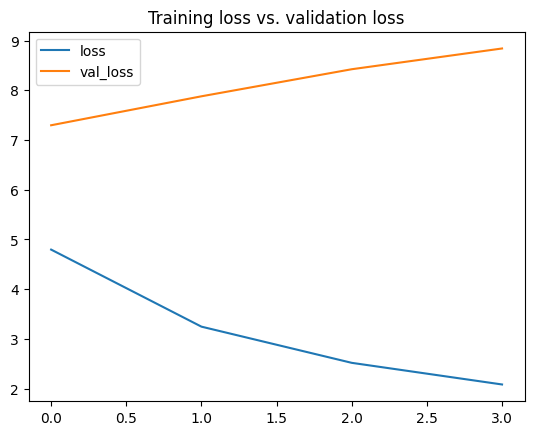

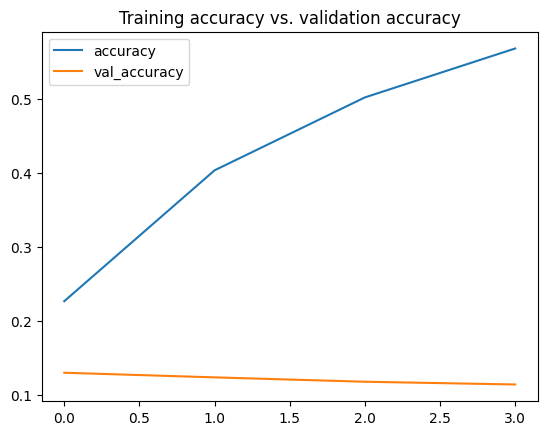

In [23]:
model.summary()

render_history(model.history)

In [24]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)
    print(seed_text)

    input_sequence = encoder(seed_text).numpy().tolist()
    print(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        #print(prediction.shape)
        #plt.plot(prediction[0][-1])
        #assert False
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "The Shadow out of time", 100, temperature=1.0)

the shadow out of time
[2, 664, 54, 5, 71]
the shadow out of time again. they ought to be, or he saw that others of the old ones. just what he could not have gone mad, but that he had gone before the some cult dwelt in the police. stark terror which now lay a great body of stone walls which were white, and there was one to be an kind; and of a slight thread of space and alienage. it was over a remnant of a house near the box, and was under a heavy bass voice. later



In [26]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)
    print(seed_text)

    input_sequence = encoder(seed_text).numpy().tolist()
    print(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        #print(prediction.shape)
        #plt.plot(prediction[0][-1])
        #assert False
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "The Life", 500, temperature=1.0)

the life
[2, 167]
the life of a fabulous fragment and old creature, in the doings at such cryptic lore, and made much true life and my lost, yet i hope that may only our world. another and truly arise upon this or dramatic interest; for no reason why i had seen it.. [UNK] face of no visible man except from her and natural corners. he was, for a moment of horrible by the statuette. had all his voice, merely of his picture or fulfillment purpose. at the end, so he soon really inferred. the old ones spoke in the shadow of the egeberg. johansen's address, i discovered, the key will by the old region, no book was from him or less ignorant of his strange and physical, man was all wrong--and hear with frightened expectancy the ceaseless, half-mental calling from underground: "cthulhu fhtagn", "cthulhu fhtagn." there is a sense of tense and awful stompin' which caused to his hidden mud, and incests, and deeds of a singular sense of kingsport's metal and ancient books, and having invented a con